In [1]:
from SCC_functions import *

In [2]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from fair import *
from fair.scripts.data_retrieval import *  # takes a long time to import

## years (time series index)
- create_years_array()

In [3]:
start_year = 1750
end_year = 2300
# start_year = 2020
# end_year = 3000

years = create_years_array(start_year, end_year)

In [4]:
## set perturbed year
SCC_year = 2022

In [5]:
## set temperature anomaly in start year
T_0 = 1.2

## consumption time series
- create_total_consumption()

In [6]:
W = create_total_consumption(years, W_fixed_year=2020, W_fixed=80)

In [7]:
d_W = {'years': years, 'W': W}

In [8]:
df_W = pd.DataFrame(data=d_W).set_index('years')

In [9]:
df_W.loc[2020]

W    80.0
Name: 2020, dtype: float64

Text(0, 0.5, 'W / $trillion')

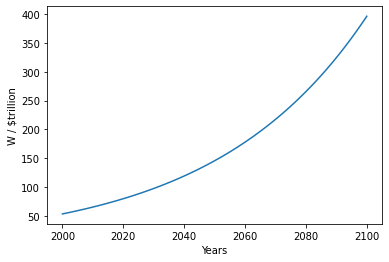

In [10]:
plt.plot(df_W.loc[2000:2100])
plt.xlabel("Years")
plt.ylabel("W / $trillion")

## discount function
- create_discount_function()

In [11]:
discount_function = create_discount_function(years, SCC_year)

In [12]:
d_discount_function = {'years': years, 'discount function': discount_function}

In [13]:
df_discount_function = pd.DataFrame(data=d_discount_function).set_index('years')

In [14]:
df_discount_function.loc[2020]

discount function    0.0
Name: 2020, dtype: float64

Text(0, 0.5, 'Discount Function')

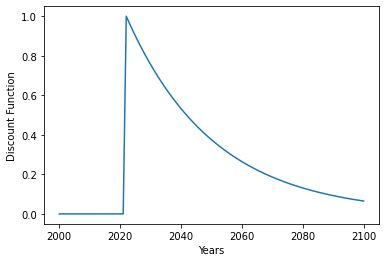

In [15]:
plt.plot(df_discount_function.loc[2000:2100])
plt.xlabel("Years")
plt.ylabel("Discount Function")

## temperature profile and perturbed temperature profile
- N.B. these can come from a geometric temperature profile or calculated from emissions through various methods

In [57]:
## set size of perturbation in GtCO2!!
## to reduce numerical error usually a larger perturbation than 1 tCO2 is used in the calculation of SCC
size_of_perturbation = 100

### 1) FaIR

In [58]:
def get_ssp_emissions(ssp):
    emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[start_year:end_year]
    ## rebase emission-driven forcings & species with natural emissions included in RCMIP to zero @ 1750
    rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
    emms.loc[:,rebase_species] -= emms.loc[1750,rebase_species]
    return emms

# choose ssp to use
ssp='ssp245'

# get emissions data using imported scripts (from 1845 onwards)
ssp_emms = get_ssp_emissions(ssp)

def get_ssp_forc(ssp,forcs=['land_use','volcanic','solar']):
    # this returns a dataframe of the required (albedo change + natural) external forcings
    ssp_erf = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float).loc[:2150]
    return pd.concat([ssp_erf[forcs].sum(axis=1)],axis=1,keys=['forcing'])

# get forcing data using auxiliary function
ssp_extforc = get_ssp_forc(ssp)

In [59]:
ssp_emms = get_ssp_emissions('ssp245')

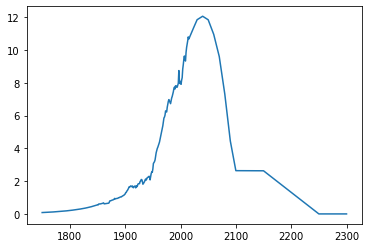

In [60]:
plt.plot(ssp_emms['carbon_dioxide'])

In [61]:
def perturb_co2(df,year):
    df = df.copy()
    df.loc[year,'carbon_dioxide'] += size_of_perturbation * 12/44 # perturbation of CO2 in GtC
    return df
# def perturb_gas(df,year,gas):
#     df = df.copy()
#     df.loc[year,gas] += 1 # perturbation of 1 GtCH4 (maybe it's MtCH4)
#     return df

perturbed_emms = pd.concat([ssp_emms]+[perturb_co2(ssp_emms,SCC_year)],keys=['ssp245']+['ssp245-p'+str(SCC_year)],axis=1)
# perturbed_emms = pd.concat([ssp_emms]+[perturb_co2(ssp_emms,year) for year in np.arange(1845,2101)],keys=['ssp245']+['ssp245-p'+str(year) for year in np.arange(1845,2101)],axis=1)
# perturbed_emms_meth = pd.concat([ssp_emms]+[perturb_gas(ssp_emms,year,'methane') for year in np.arange(1845,2101)],keys=['ssp245']+['ssp245-p'+str(year) for year in np.arange(1845,2101)],axis=1)

In [62]:
test_gas_parameters = get_gas_parameter_defaults()

test_thermal_parameters = get_thermal_parameter_defaults()

# pulse_emissions = return_empty_emissions(df_to_copy=False, start_year=start_year, end_year=end_year, timestep=1, scen_names=['None']+[x+'pulse' for x in ['carbon_dioxide']], gases_in = ['carbon_dioxide','methane','nitrous_oxide'])


# for gas in ['carbon_dioxide']:
    
#     pulse_emissions.loc[SCC_year,(gas+'pulse',gas)] += size_of_perturbation * 12/44
    
# Now generate a compatible forcing dataframe:

pulse_forcing = return_empty_forcing(perturbed_emms)

test_gas_parameters = test_gas_parameters.reindex(perturbed_emms.columns.levels[1],axis=1,level=1)

# And run the model!

pulse_run = run_FaIR(emissions_in=perturbed_emms,forcing_in=pulse_forcing,gas_parameters=test_gas_parameters,thermal_parameters=test_thermal_parameters)

Integrating 2 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'halon1202', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'nox_avi'] forcing agents, between 1750 and 2300...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:00<00:00, 3904.23 timestep/s]


Text(0, 0.5, 'Warming')

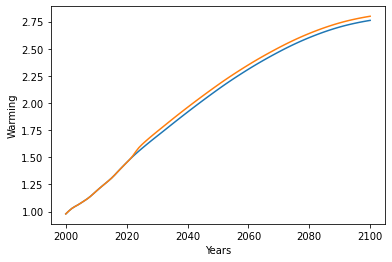

In [63]:
plt.plot(pulse_run['T'].loc[2000:2100])
plt.xlabel("Years")
plt.ylabel("Warming")

In [64]:
T = pulse_run['T']['ssp245']['default'].tolist()

T_perturbed = pulse_run['T']['ssp245-p'+str(SCC_year)]['default'].tolist()

In [65]:
# # Generate a default parameter dataframe:

# test_gas_parameters = get_gas_parameter_defaults()

# test_thermal_parameters = get_thermal_parameter_defaults()

# pulse_emissions = return_empty_emissions(df_to_copy=False, start_year=start_year, end_year=end_year, timestep=1, scen_names=['None']+[x+'pulse' for x in ['carbon_dioxide']], gases_in = ['carbon_dioxide','methane','nitrous_oxide'])

# # add pulses in year 10 (the units are GtC, MtCH4 and MtN2O-N2):

# for gas in ['carbon_dioxide']:
    
#     pulse_emissions.loc[SCC_year,(gas+'pulse',gas)] += size_of_perturbation * 12/44
    
# # Now generate a compatible forcing dataframe:

# pulse_forcing = return_empty_forcing(pulse_emissions)

# test_gas_parameters = test_gas_parameters.reindex(pulse_emissions.columns.levels[1],axis=1,level=1)

# # And run the model!

# pulse_run = run_FaIR(emissions_in=pulse_emissions,forcing_in=pulse_forcing,gas_parameters=test_gas_parameters,thermal_parameters=test_thermal_parameters)

# plt.plot(pulse_run['T'])

# T = pulse_run['T']['None']['default'].tolist()

# T_perturbed = pulse_run['T']['carbon_dioxidepulse']['default'].tolist()

# calculate SCC

- SCC_calculator()

In [66]:
## define damage function values
gamma=2
D0=0.00267

create time series data frame

In [67]:
time_series_data = {'years': years, 'W': W, 'discount function': discount_function, 'T': T, 'T perturbed': T_perturbed}

time_series_df = pd.DataFrame(data=time_series_data).set_index('years')

In [68]:
time_series_df

,W,discount function,T,T perturbed
years,,,,
1750,0.361326,0.000000,0.000201,0.000201
1751,0.368626,0.000000,0.000954,0.000954
1752,0.376072,0.000000,0.002271,0.002271
1753,0.383670,0.000000,0.003786,0.003786
1754,0.391420,0.000000,0.005060,0.005060
...,...,...,...,...
2296,19970.802975,0.000068,3.145251,3.188651
2297,20374.239957,0.000066,3.145828,3.189253
2298,20785.826906,0.000064,3.146410,3.189860


In [69]:
SCC_calculator(time_series_df, size_of_perturbation=size_of_perturbation, gamma=gamma, D0=D0)

27.830002498660026